In [1]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available! You can use GPU acceleration.")
else:
    print("CUDA is not available. Using CPU instead.")

CUDA is available! You can use GPU acceleration.


# Load the dump model

In [2]:
import contextlib
import io
import os
import random
import warnings


def ids_tensor(shape, vocab_size, rng=None, name=None):
    #  Creates a random int32 tensor of the shape within the vocab size
    import torch

    if rng is None:
        rng = random.Random()

    total_dims = 1
    for dim in shape:
        total_dims *= dim

    values = []
    for _ in range(total_dims):
        values.append(rng.randint(0, vocab_size - 1))

    return torch.tensor(data=values, dtype=torch.long).view(shape).contiguous()


def get_llama_model(
    input_dims=[(2, 1024)],
    hidden_size=1024,  # 4096,
    num_hidden_layers=1,
    vocab_size=32000,
    intermediate_size=11008,
    max_position_embeddings=2048,
    num_attention_heads=4,  # 32,
    _attn_implementation="eager",
    with_mask: bool = True,
):
    import torch
    from transformers import LlamaConfig
    from transformers.models.llama.modeling_llama import LlamaModel

    config = LlamaConfig(
        num_hidden_layers=num_hidden_layers,
        vocab_size=vocab_size,
        hidden_size=hidden_size,
        intermediate_size=intermediate_size,
        max_position_embeddings=max_position_embeddings,
        num_attention_heads=num_attention_heads,
    )
    if _attn_implementation:
        config._attn_implementation = _attn_implementation

    class LlamaModelWrapper(torch.nn.Module):
        def __init__(self, config):
            super().__init__()
            self.model = LlamaModel(config)

        def forward(self, input_ids, attention_mask):
            model_output = self.model(input_ids, attention_mask=attention_mask)
            return model_output.to_tuple()

    def generate_example_inputs(batch: int, seq: int, vocab_size: int):
        input_ids = ids_tensor([batch, seq], vocab_size)
        input_mask = torch.tril(torch.ones(batch, seq, dtype=torch.float32))
        assert input_mask.dtype == torch.float32
        return input_ids, input_mask

    example_args_collection = []
    for b, s in input_dims:
        example_args_collection.append(generate_example_inputs(b, s, vocab_size))

    return LlamaModelWrapper(config), example_args_collection


print("creation of the model.")
model, example_args_collection = get_llama_model()
print("done.")

creation of the model.


c:\Users\Paul\.conda\envs\GPU\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


done.


In [3]:
# Module
print(model)

LlamaModelWrapper(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 1024)
    (layers): ModuleList(
      (0): LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=1024, out_features=11008, bias=False)
          (up_proj): Linear(in_features=1024, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
)


In [4]:
# Run the model
input_dim = (2, 1024)
example_arg = example_args_collection[0]
model(*example_args_collection[0])

(tensor([[[ 0.6538,  1.4923, -1.0207,  ..., -0.9500, -0.6047,  0.2421],
          [ 0.5902,  1.5998, -1.2004,  ..., -1.0070, -0.4677,  0.1595],
          [ 0.5829,  1.4299, -1.1225,  ..., -1.1021, -0.3678,  0.2983],
          ...,
          [ 0.5308,  1.5105, -1.1224,  ..., -1.0443, -0.4936,  0.1287],
          [ 0.4995,  1.5303, -1.1162,  ..., -1.1316, -0.5139,  0.1244],
          [ 0.5986,  1.3492, -1.1980,  ..., -1.0503, -0.5308,  0.0821]],
 
         [[ 1.0960,  0.2340,  0.7139,  ..., -0.1365, -0.6959,  1.3350],
          [ 1.0510, -0.8339, -0.3548,  ...,  0.7212, -0.2489,  1.1318],
          [ 0.8738,  0.0459,  0.1464,  ...,  0.4444, -0.5898,  1.5109],
          ...,
          [ 0.8249, -0.5053, -0.2931,  ...,  0.6251,  0.5112,  1.1570],
          [ 0.7034, -0.7555, -0.4960,  ...,  0.9936,  0.5579,  0.5991],
          [ 0.4533, -0.7071, -0.2579,  ...,  0.1992,  0.0167,  0.8224]]],
        grad_fn=<MulBackward0>),
 ((tensor([[[[-0.1522,  0.6797,  0.9572,  ...,  0.3198, -0.9724,  0.

# About the dump model

The wrapping boils down to:
```
- wrapper
    - model
        - LlamaDecoderLayer
```
The model then is:  
![Llama model](llama.jpg)

Which corresponds on the netron model to:  
![Netron labeled](llama_netron_labeled.jpg)

In [5]:
# Step by step
from transformers.cache_utils import Cache, DynamicCache, StaticCache
from transformers.modeling_outputs import BaseModelOutputWithPast

# args
input_ids, attention_mask = example_arg
_model = model.model

# Forward
output_attentions = _model.config.output_attentions
output_hidden_states = _model.config.output_hidden_states
use_cache = _model.config.use_cache
return_dict = _model.config.use_return_dict
inputs_embeds = _model.embed_tokens(input_ids)

past_seen_tokens = 0
if not isinstance(None, StaticCache):
    past_key_values = DynamicCache.from_legacy_cache(None)
    past_seen_tokens = past_key_values.get_seq_length()

if isinstance(past_key_values, StaticCache):
    raise ValueError("cache_position is a required argument when using StaticCache.")
cache_position = torch.arange(
    past_seen_tokens, past_seen_tokens + inputs_embeds.shape[1], device=inputs_embeds.device
)

position_ids = cache_position.unsqueeze(0)
causal_mask = _model._update_causal_mask(attention_mask, inputs_embeds, cache_position, past_seen_tokens)

# embed positions
hidden_states = inputs_embeds

# decoder layers
all_hidden_states = None
all_self_attns = None
next_decoder_cache = None

decoder_layer = _model.layers[0]

# forward from decoder layer
attention_mask=causal_mask
position_ids=position_ids
past_key_value=past_key_values
output_attentions=output_attentions
use_cache=use_cache
cache_position=cache_position

residual = hidden_states
hidden_states = decoder_layer.input_layernorm(hidden_states) # hidden_states is x

# Self Attention
hidden_states, self_attn_weights, present_key_value = decoder_layer.self_attn(
    hidden_states=hidden_states,
    attention_mask=attention_mask,
    position_ids=position_ids,
    past_key_value=past_key_value,
    output_attentions=output_attentions,
    use_cache=use_cache,
    cache_position=cache_position
)
hidden_states = residual + hidden_states

# Fully Connected
residual = hidden_states
hidden_states = decoder_layer.post_attention_layernorm(hidden_states)
mlp_input = hidden_states # for mlp fuzed kernel
hidden_states = decoder_layer.mlp(hidden_states)
hidden_states = residual + hidden_states

outputs = (hidden_states,)

# if output_attentions:
#     outputs += (self_attn_weights,)

outputs += (present_key_value,)

layer_outputs = outputs
# end of forward from decoder layer

hidden_states = layer_outputs[0]

next_decoder_cache = layer_outputs[2 if output_attentions else 1]

hidden_states = _model.norm(hidden_states)

# add hidden states from the last decoder layer
if output_hidden_states:
    all_hidden_states += (hidden_states,)

next_cache = None
if use_cache:
    next_cache = (
        next_decoder_cache.to_legacy_cache() if isinstance(next_decoder_cache, Cache) else next_decoder_cache
    )

_return = BaseModelOutputWithPast(
last_hidden_state=hidden_states,
past_key_values=next_cache,
hidden_states=all_hidden_states,
attentions=all_self_attns,
)

# mlp fuzed kernel

In [6]:
# Isolate the MLP
mlp = decoder_layer.mlp
torch.onnx.export(
    mlp,
    (mlp_input,),
    "mlp.onnx",
)

The `mlp` module actually correspond to a gated multi-layer perceptron.  
See https://arxiv.org/pdf/2002.05202 as a reference (we later call the Swish function SiLU). 
The gated linear unit returns:  
`self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))`, that is to say:
$$(\sigma(X \times G^T) \odot (X \times U^T)) \times D^T$$
With the shapes:
- $X: n,d$
- $U: \tilde{d},d$
- $G: \tilde{d},d$
- $D: d,\tilde{d}$  

$\sigma$ corresponds to the $SiLU$ activation function: $\sigma(x)=x*sigmoid(x)$

![MLP netron labeled](figures/mlp_netron_labeled.png)

In [7]:
# Parameters
hidden_size = _model.config.hidden_size
intermediate_size = _model.config.intermediate_size
mlp_input_shape = mlp_input.shape
G = mlp.gate_proj.weight
U = mlp.up_proj.weight
D = mlp.down_proj.weight

# Forward
X = mlp_input
output = mlp(mlp_input)
act_fn = torch.nn.SiLU()
_ = (act_fn(X@G.T)*(X@U.T)) @ D.T
assert torch.allclose(output, _)

# Export

In [8]:
# Export
torch.save(mlp,"mlp.pt")
torch.save(mlp_input,"mlp_input.pt")

# Triton kernel
https://developer.nvidia.com/blog/cuda-refresher-cuda-programming-model/  
https://triton-lang.org/main/getting-started/tutorials/01-vector-add.html

I start by exploring my GPU characteristics, using CUDA demo suite `deviceQuery` (`Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1\extras\demo_suite`):
```
Device 0: "NVIDIA GeForce GTX 950M"
  CUDA Driver Version / Runtime Version          12.1 / 12.1
  CUDA Capability Major/Minor version number:    5.0
  Total amount of global memory:                 2048 MBytes (2147352576 bytes)
  ( 5) Multiprocessors, (128) CUDA Cores/MP:     640 CUDA Cores
  GPU Max Clock rate:                            1124 MHz (1.12 GHz)
  Memory Clock rate:                             1001 Mhz
  Memory Bus Width:                              128-bit
  L2 Cache Size:                                 2097152 bytes
  Maximum Texture Dimension Size (x,y,z)         1D=(65536), 2D=(65536, 65536), 3D=(4096, 4096, 4096)
  Maximum Layered 1D Texture Size, (num) layers  1D=(16384), 2048 layers
  Maximum Layered 2D Texture Size, (num) layers  2D=(16384, 16384), 2048 layers
  Total amount of constant memory:               zu bytes
  Total amount of shared memory per block:       zu bytes
  Total number of registers available per block: 65536
  Warp size:                                     32
  Maximum number of threads per multiprocessor:  2048
  Maximum number of threads per block:           1024
  Max dimension size of a thread block (x,y,z): (1024, 1024, 64)
  Max dimension size of a grid size    (x,y,z): (2147483647, 65535, 65535)
  Maximum memory pitch:                          zu bytes
  Texture alignment:                             zu bytes
  Concurrent copy and kernel execution:          Yes with 4 copy engine(s)
  Run time limit on kernels:                     Yes
  Integrated GPU sharing Host Memory:            No
  Support host page-locked memory mapping:       Yes
  Alignment requirement for Surfaces:            Yes
  Device has ECC support:                        Disabled
  CUDA Device Driver Mode (TCC or WDDM):         WDDM (Windows Display Driver Model)
  Device supports Unified Addressing (UVA):      Yes
  Device supports Compute Preemption:            No
  Supports Cooperative Kernel Launch:            No
  Supports MultiDevice Co-op Kernel Launch:      No
  Device PCI Domain ID / Bus ID / location ID:   0 / 1 / 0
  Compute Mode:
     < Default (multiple host threads can use ::cudaSetDevice() with device simultaneously) >
```

I need to compute:
$$
\begin{cases}
    Z =  & X \times G^T\\
    \tilde{Z} = & Z \odot sigmoid(Z) \odot (X\times U^T)\\
    ... = & \tilde{Z} \times D^T
  \end{cases}$$

I propose the following parallelization scheme:
- Compute $Z$ and $X \times U^T$ in parallel
- Compute $sigmoid(Z)$
- Compute the triple element wise multiplication for $\tilde{Z}$
- Compute $\tilde{Z} \times D^T$  

The first step is natively implemented when using
$X \times ( 
    \begin{array}{c}
    G^T \\
    U^T \\
    \end{array}
    )$
and masks to retrieve results.
The novelty is step 3, that is to say a kernel for triple elementwise matrix multiplication.
Performance improvements from other steps will not come from parallelization but from cach usage optimization.

With a naive implementation, I get the following performance:  
![Naive triton kernel](figures/naive_triton_kernel.png)

# FUSED MLP kernel 

In [ ]:
import torch

import triton
import triton.language as tl

from triton_kernel import kernel_ff
from pytorch_kernel import ff_pytorch
from pytorch_kernel import rms_norm_pytorch

from utils import f16_to_f8

# standard deviation of the weight distribution is 0.2 for numerical stability

rms_w = torch.randn([4096], dtype=torch.float16, device="cuda") * 0.2
x = torch.randn([1, 16, 4096], dtype=torch.float16, device="cuda")
x = rms_norm_pytorch(x, rms_w, eps=1e-6)

# weights tend to be very small values
w1_w = torch.randn([11008, 4096], dtype=torch.float16, device="cuda") * 0.2
w3_w = torch.randn([11008, 4096], dtype=torch.float16, device="cuda") * 0.2

# Convert weights to FP8 and test the Triton kernel with FP8 weights
w1_w_fp8 = f16_to_f8(w1_w, dtypes=tl.float8e5)
w3_w_fp8 = f16_to_f8(w3_w, dtypes=tl.float8e5)


# Compare Triton and PyTorch outputs
output_triton = kernel_ff(x=x, w1=w1_w, w3=w3_w)
output_triton_fp8 = kernel_ff(x=x, w1=w1_w_fp8, w3=w3_w_fp8)
output_pytorch = ff_pytorch(x=x, w1=w1_w, w3=w3_w)


# max difference between the three implementations
print("max between triton fp8 and without fp8 in triton",max(torch.abs(output_triton - output_triton_fp8).flatten()))
print("max between pytorch and triton(without fp8)",max(torch.abs(output_triton - output_triton).flatten()))
print("max between pytorch and triton(without fp8)",max(torch.abs(output_triton - output_triton_fp8).flatten()))

# Validate the results
if torch.allclose(output_triton, output_pytorch, atol=1e-1):
    print("✅ Triton and Torch match in the range of 1e-1")
else:
    print("❌ Triton and Torch differ in the range of 1e-1")

# Benchmarking the PyTorch implementation
print("rms matmul silu mul pytorch", triton.testing.do_bench(lambda: ff_pytorch(x=x, w1=w1_w, w3=w3_w)))

# Benchmarking the Triton implementation without FP8 weights
print("rms matmul silu mul triton", triton.testing.do_bench(lambda: kernel_ff(x=x, w1=w1_w, w3=w3_w)))

# Benchmarking the Triton implementation with FP8 weights
# when use fp8, on very large tensors, it is expected that the error is large, we just check it is not crazy large
print("rms matmul silu mul triton fp8", triton.testing.do_bench(lambda: kernel_ff(x=x, w1=w1_w_fp8, w3=w3_w_fp8)))



max between triton fp8 and without fp8 in triton tensor(3.9375, device='cuda:0', dtype=torch.float16)
max between pytorch and triton(without fp8) tensor(0., device='cuda:0', dtype=torch.float16)
max between pytorch and triton(without fp8) tensor(3.9375, device='cuda:0', dtype=torch.float16)
✅ Triton and Torch match in the range of 1e-1
rms matmul silu mul pytorch 0.6611626744270325
rms matmul silu mul triton 0.5943467020988464
rms matmul silu mul triton fp8 0.5135359764099121


 `triton.testing.do_bench` provides detailed information on the performance of the `kernel_ff` function in terms of execution time on the GPU, which is crucial for evaluating and optimising the performance of CUDA kernels.

# Fused RMSnorm + MLP kernel into one 


![RMSNorm](figures/RMSNorm_arxiv.png)


See https://arxiv.org/abs/1910.07467 as a reference. 

and then on X_normalized

$$
\begin{cases}
    Z =  & X_{normalized} \times G^T\\
    \tilde{Z} = & Z \odot sigmoid(Z) \odot (X_{normalized}\times U^T)\\
    ... = & \tilde{Z} \times D^T
\end{cases}$$

l'idée est de combiner 2 étapes de calcul en une seule boucle optimisée, réduisant ainsi les redondances de loader l'output après la normalisation pour améliorer l'efficacité globale du modèle.


L'objectif est d'optimiser la section feed-forward du modèle LLAMA pour améliorer les performances. Voici les étapes et l'idée générale de ce que nous voulons coder :

1. **Normalisation RMS (RMSNorm) :** Appliquer une normalisation RMS à l'entrée une seule fois et réutiliser cette sortie normalisée pour les opérations suivantes. Actuellement, `x_norm` est calculé une fois puis utilisé dans deux multiplications matricielles séparées.

2. **Multiplications Matricielles en Chaîne :** Enchaîner les deux multiplications matricielles dans une seule boucle pour réduire les accès mémoire et améliorer l'efficacité. La première multiplication matricielle est suivie par une opération `silu` (qui combine une multiplication et une activation sigmoïde), puis une deuxième multiplication matricielle est effectuée.

3. **Fusion des Opérations :** Fusionner l'opération `silu` avec la sortie de la première multiplication matricielle pour éviter des opérations redondantes. Cette fusion implique de combiner les opérations élémentaires de manière à ce qu'elles soient effectuées en une seule étape.

4. **Optimisation des Statistiques RMS :** Calculer et appliquer les statistiques RMS dans la même boucle que les multiplications matricielles, réduisant ainsi le nombre de passes nécessaires sur les données.

5. **Amélioration des Performances :** En rationalisant ces opérations, le nouveau noyau sera plus rapide que l'implémentation actuelle en PyTorch. Les optimisations visent à réduire le temps d'exécution en minimisant les opérations redondantes et en améliorant l'utilisation des ressources.



In [ ]:
import torch

import triton
import triton.language as tl

from triton_kernel import kernel_ff_with_rmsnorm
from pytorch_kernel import ff_pytorch_with_rmsnorm

from utils import f16_to_f8

# Example usage
x = torch.randn([1, 16, 4096], dtype=torch.float16, device="cuda")
# weights tends to be very small values
rms_w = torch.randn([4096], dtype=torch.float16, device="cuda") * 0.2
w1_w = torch.randn([11008, 4096], dtype=torch.float16, device="cuda") * 0.2
w3_w = torch.randn([11008, 4096], dtype=torch.float16, device="cuda") * 0.2


# Compare Triton and PyTorch outputs
output_triton = kernel_ff_with_rmsnorm(x=x, w1=w1_w, w3=w3_w, rms_w=rms_w)
output_pytorch = ff_pytorch_with_rmsnorm(x=x, w1=w1_w, w3=w3_w, rms_w=rms_w)

# Validate the results
if torch.allclose(output_triton, output_pytorch, atol=1e-1):
    print("✅ Triton and Torch match in the range of 1e-1")
else:
    print("❌ Triton and Torch differ in the range of 1e-1")

# Benchmarking the PyTorch implementation
print("rms matmul silu mul pytorch", triton.testing.do_bench(lambda: ff_pytorch_with_rmsnorm(x=x, w1=w1_w, w3=w3_w, rms_w=rms_w)))

# Benchmarking the Triton implementation
print("rms matmul silu mul triton", triton.testing.do_bench(lambda: kernel_ff_with_rmsnorm(x=x, w1=w1_w, w3=w3_w, rms_w=rms_w)))


# Convert weights to FP8 and test the Triton kernel with FP8 weights
w1_w_fp8 = f16_to_f8(w1_w, dtypes=tl.float8e5)
w3_w_fp8 = f16_to_f8(w3_w, dtypes=tl.float8e5)
rms_w_fp8 = f16_to_f8(rms_w, dtypes=tl.float8e5)

out_fp8 = kernel_ff_with_rmsnorm(x=x, w1=w1_w_fp8, w3=w3_w_fp8, rms_w=rms_w_fp8)


# Benchmarking the Triton implementation with FP8 weights
print("rms matmul silu mul triton fp8", triton.testing.do_bench(lambda: kernel_ff_with_rmsnorm(x=x, w1=w1_w_fp8, w3=w3_w_fp8, rms_w=rms_w_fp8)))


✅ Triton and Torch match in the range of 1e-1
rms matmul silu mul pytorch 0.8860029578208923
rms matmul silu mul triton 0.7686074376106262
rms matmul silu mul triton fp8 0.7192997932434082


 `triton.testing.do_bench` fournit des informations détaillées sur la performance de la fonction `kernel_ff` en termes de temps d'exécution sur le GPU, ce qui est crucial pour évaluer et optimiser les performances des noyaux CUDA.

# Benchmark performance when variyng input  size

## --MLP (without RMSNorm, without quantization) Benchmark

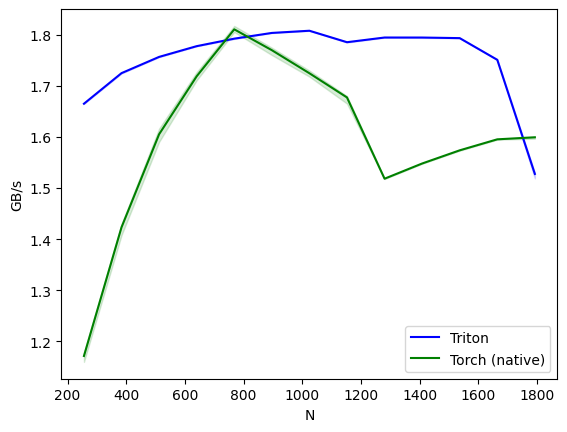

kernel-performance:
         N    Triton  Torch (native)
0    256.0  1.665041        1.171625
1    384.0  1.724874        1.423375
2    512.0  1.756621        1.605330
3    640.0  1.777623        1.718697
4    768.0  1.792299        1.810520
5    896.0  1.803497        1.769767
6   1024.0  1.807790        1.724632
7   1152.0  1.785354        1.677314
8   1280.0  1.794524        1.518387
9   1408.0  1.794488        1.548103
10  1536.0  1.793345        1.573871
11  1664.0  1.750888        1.595398
12  1792.0  1.527707        1.599420


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 15)],  # Réduisez la plage des valeurs de `N`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
        ],  # possible values for `line_arg`
        line_names=[
            "Triton",
            "Torch (native)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="kernel-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    batch = 1
    seq_len = M
    dim = N
    x = torch.randn(batch, seq_len, dim, device='cuda', dtype=torch.float16)
    w1 = torch.randn(11008, dim, device='cuda', dtype=torch.float16) * 0.2
    w3 = torch.randn(11008, dim, device='cuda', dtype=torch.float16) * 0.2
    #rms_w = torch.randn(dim, device='cuda', dtype=torch.float16) * 0.2
    quantiles = [0.5, 0.2, 0.8]

    if provider == 'torch-native':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ff_pytorch(x, w1, w3), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: ff_pytorch_with_rmsnorm(x, w1, w3,rms_w), quantiles=quantiles)
    elif provider == 'triton':
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernel_ff(x, w1, w3), quantiles=quantiles)
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernel_ff_with_rmsnorm(x, w1, w3,rms_w), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots=True, print_data=True)

# -- MLP + RMSNorm Benchmark

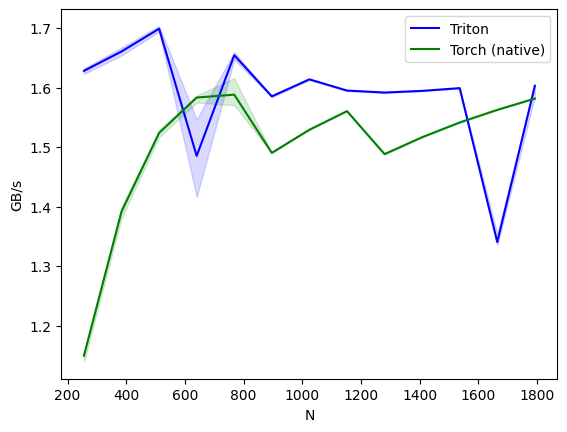

kernel-performance:
         N    Triton  Torch (native)
0    256.0  1.627981        1.149593
1    384.0  1.660541        1.391620
2    512.0  1.698704        1.523668
3    640.0  1.485134        1.583179
4    768.0  1.654281        1.588007
5    896.0  1.585139        1.490229
6   1024.0  1.613710        1.529071
7   1152.0  1.594878        1.560315
8   1280.0  1.591545        1.488102
9   1408.0  1.594338        1.516526
10  1536.0  1.598959        1.541298
11  1664.0  1.340382        1.562441
12  1792.0  1.602952        1.581467


In [ ]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['N'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(2, 15)],  # Réduisez la plage des valeurs de `N`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=[
            'triton',
            'torch-native',
        ],  # possible values for `line_arg`
        line_names=[
            "Triton",
            "Torch (native)",
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-')],  # line styles
        ylabel="GB/s",  # label name for the y-axis
        plot_name="kernel-performance",  # name for the plot. Used also as a file name for saving the plot.
        args={'M': 4096},  # values for function arguments not in `x_names` and `y_name`
    ))
def benchmark(M, N, provider):
    batch = 1
    seq_len = M
    dim = N
    x = torch.randn(batch, seq_len, dim, device='cuda', dtype=torch.float16)
    w1 = torch.randn(11008, dim, device='cuda', dtype=torch.float16) * 0.2
    w3 = torch.randn(11008, dim, device='cuda', dtype=torch.float16) * 0.2
    rms_w = torch.randn(dim, device='cuda', dtype=torch.float16) * 0.2
    quantiles = [0.5, 0.2, 0.8]

    if provider == 'torch-native':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: ff_pytorch(x, w1, w3), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: ff_pytorch_with_rmsnorm(x, w1, w3,rms_w), quantiles=quantiles)
    elif provider == 'triton':
        #ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernel_ff(x, w1, w3), quantiles=quantiles)
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: kernel_ff_with_rmsnorm(x, w1, w3,rms_w), quantiles=quantiles)
    gbps = lambda ms: 2 * x.nelement() * x.element_size() * 1e-9 / (ms * 1e-3)
    return gbps(ms), gbps(max_ms), gbps(min_ms)

benchmark.run(show_plots=True, print_data=True)